# Library

In [1]:
! pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 494.9 kB/s eta 0:00:00


In [2]:
import os
import random
import time
import pickle
import psutil
import gc
from tqdm.auto import tqdm


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2


import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric

# setting some globl config

plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

INFERENCE = True

In [3]:
# Read data
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')

In [4]:
# Shape of data
data.shape

(401626, 18)

In [5]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


# Train test split

In [6]:
# Split data into train and test
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [7]:
# Split train_data into train and valid
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

In [8]:
# columns of our data
train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

# Feature Engineering

## PACF

This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

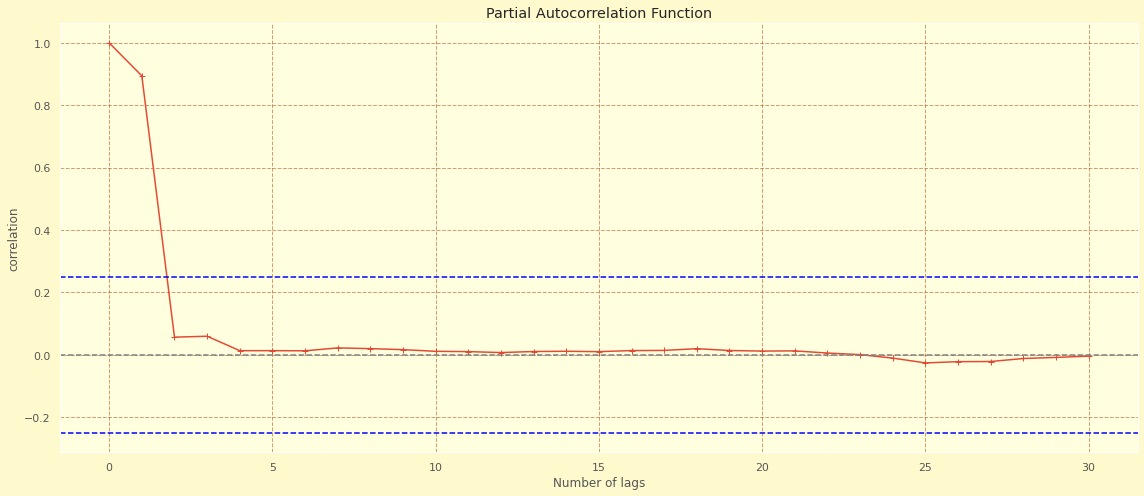

In [9]:
y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [10]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    
    # We rename the columùns by adding lag_{lag_value} at the end
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [11]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

# Configuration

In [12]:
class CFG:
    DEBUG = False # Test functions
    model = 'tabnet' # model name
    N_folds = 5 # Number of folds
    seed = 42 # Seed values
    batch_size = 2048 
    max_epochs = 60

In [13]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [14]:
# Statistics about memory usage
psutil.virtual_memory().percent

10.2

In [15]:
model = TabNetRegressor(n_d = 28, # Width of the decision prediction layer
                        n_a = 28, # Width of the attention embedding for each mask
                        n_steps = 2, # Number of steps in the architecture
                        gamma = 1.3, # coefficient for feature reusage in the masks
                        n_independent = 1, # Number of independent Gated Linear Units layers at each step
                        n_shared = 2, # Number of shared Gated Linear Units at each step
                        momentum = 0.02, # Momentum for batch normalization
                        clip_value = None, # extra sparsity loss coefficient
                        lambda_sparse = 1e-3,
                        optimizer_fn = torch.optim.Adam, # Adam optimizer
                        optimizer_params = dict(lr = 1e-3, weight_decay=1e-3), # Optimizer params
                        scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 
                        scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                        mask_type = 'entmax', # masking function to use for selecting features
                        device_name='cuda', # Run on gpu
                        seed = CFG.seed)
# Model Trining
model.fit(X_train=train[features_columns].values, y_train=np.log(train['PM2.5'].values.reshape(-1, 1)),
          eval_set=[(valid[features_columns].values, np.log(valid['PM2.5'].values.reshape(-1, 1)))],
          eval_name=['valid'],
          eval_metric=['mae', 'rmsle', 'rmse'], # Last metric is used for early stopping
          max_epochs = CFG.max_epochs,
          patience = 50,
          virtual_batch_size = 32,
          batch_size = CFG.batch_size)

# Predictions and score on validation data
pred_val = model.predict(valid[features_columns].values)
pred_test = model.predict(test[features_columns].values)

# Calculate scores on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))

# Calculate scores on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
msle_score_test = msle(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
print("\n")

print(f"Tabnet Regressor rmse valid: {sqrt(mse_score_valid)}")
print(f"Tabnet Regressor mae valid: {mae_score_valid}")
print(f"Tabnet Regressor rmsle valid: {sqrt(msle_score_valid)}")
print(f"Tabnet Regressor r2 valid: {r2_score_valid}")

print('\n')

print(f"Tabnet Regressor rmse test: {sqrt(mse_score_test)}")
print(f"Tabnet Regressor mae test: {mae_score_test}")
print(f"Tabnet Regressor rmsle test: {sqrt(msle_score_test)}")
print(f"Tabnet Regressor r2 test: {r2_score_test}")

epoch 0  | loss: 2.52668 | valid_mae: 1.33563 | valid_rmsle: 0.10737 | valid_rmse: 1.99548 |  0:00:15s
epoch 1  | loss: 0.48762 | valid_mae: 0.7625  | valid_rmsle: 0.0461  | valid_rmse: 0.94847 |  0:00:30s
epoch 2  | loss: 0.34851 | valid_mae: 0.58553 | valid_rmsle: 0.03855 | valid_rmse: 0.8834  |  0:00:47s
epoch 3  | loss: 0.30158 | valid_mae: 0.36518 | valid_rmsle: 0.01459 | valid_rmse: 0.50089 |  0:01:02s
epoch 4  | loss: 0.28418 | valid_mae: 0.33015 | valid_rmsle: 0.01254 | valid_rmse: 0.459   |  0:01:17s
epoch 5  | loss: 0.25497 | valid_mae: 0.29221 | valid_rmsle: 0.01076 | valid_rmse: 0.41136 |  0:01:32s
epoch 6  | loss: 0.21909 | valid_mae: 0.27201 | valid_rmsle: 0.0097  | valid_rmse: 0.38149 |  0:01:47s
epoch 7  | loss: 0.19671 | valid_mae: 0.25055 | valid_rmsle: 0.00912 | valid_rmse: 0.36223 |  0:02:02s
epoch 8  | loss: 0.18439 | valid_mae: 0.24721 | valid_rmsle: 0.00871 | valid_rmse: 0.35417 |  0:02:17s
epoch 9  | loss: 0.17876 | valid_mae: 0.24488 | valid_rmsle: 0.00856 | va

# Tabnet CV

In [16]:
print('\n ', '-'*50)
print('\nTraining: ', CFG.model)
print('\n ', '-'*50)

print('\nSeed: ', CFG.seed)
print('N folds: ', CFG.N_folds)
print('train shape: ', train_data.shape)
print('targets shape: ', train_data['PM2.5'].shape)


print('\nN features: ', len(features_columns))
print('\n')

# Create out of folds array
oof_tabnet = np.zeros((train_data.shape[0]))
predictions_tabnet = np.zeros(test.shape[0])
feature_importances = pd.DataFrame()
feature_importances["feature"] = features_columns
stats = pd.DataFrame()
explain_matrices = []
masks_ =[]
mse_scores_tabnet = []
mae_scores_tabnet = []
msle_scores_tabnet = []
r2_scores_tabnet = []

# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

    
tsp = TimeSeriesSplit(n_splits=CFG.N_folds, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

# Iterate over the whole folds
for fold, (trn_idx, vld_idx) in enumerate(tsp.split(train_data)):

    ## DEBUG MODE
    if CFG.DEBUG == True:
        if fold > 0:
            print('\nDEBUG mode activated: Will train only one fold...\n')
            break      

    start = time.time()
    
    # Split data into train and valid
    X_train, y_train = train_data.iloc[trn_idx][features_columns].values, np.log(train_data.iloc[trn_idx]['PM2.5'].values.reshape(-1, 1))
    X_valid, y_valid = train_data.iloc[vld_idx][features_columns].values, np.log(train_data.iloc[vld_idx]['PM2.5'].values.reshape(-1, 1))
    
    # Tabnet regressor params
    model = TabNetRegressor(n_d = 28, # Width of the decision prediction layer
                            n_a = 28, # Width of the attention embedding for each mask
                            n_steps = 2, # Number of steps in the architecture
                            gamma = 1.3, # coefficient for feature reusage in the masks
                            n_independent = 1, # Number of independent Gated Linear Units layers at each step
                            n_shared = 2, # Number of shared Gated Linear Units at each step
                            momentum = 0.02, # Momentum for batch normalization
                            clip_value = None, # extra sparsity loss coefficient
                            lambda_sparse = 1e-3,
                            optimizer_fn = torch.optim.Adam, # Adam optimizer
                            optimizer_params = dict(lr = 1e-3, weight_decay=1e-3), # Optimizer params
                            scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 
                            scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                            mask_type = 'entmax', # masking function to use for selecting features
                            device_name='cuda', # Run on gpu
                            seed = CFG.seed)
    
    ## train
    model.fit(X_train,
              y_train,
              eval_set = [(X_valid, y_valid)],
              max_epochs = CFG.max_epochs,
              patience = 50,
              virtual_batch_size = 64,
              batch_size = CFG.batch_size,
              eval_metric = ['mae', 'rmsle', 'rmse']) # Last metric is used for early stopping
    
    # Predictions and score on validation data
    pred_val = model.predict(X_valid)
    pred_test = model.predict(test[features_columns].values)
    
    # model explanability
    explain_matrix, masks = model.explain(X_valid)
    explain_matrices.append(explain_matrix)
    masks_.append(masks[0])
    masks_.append(masks[1])
      
    # Calculate the scores on the validation data
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    msle_score_valid = msle(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    
    print('\n')
    print(f"Fold {fold} Tabnet rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {fold} Tabnet  mae: {mae_score_valid}")
    print(f"Fold {fold} Tabnet rmsle: {sqrt(msle_score_valid)}")
    print(f"Fold {fold} Tabnet r2: {r2_score_valid}")
    print('\n')
    
    # Register the score on each fold
    mse_scores_tabnet.append(sqrt(mse_score_valid))
    mae_scores_tabnet.append(mae_score_valid)
    msle_scores_tabnet.append(sqrt(msle_score_valid))
    r2_scores_tabnet.append(r2_score_valid)
    
    # Inference
    oof_tabnet[vld_idx] = pred_val.ravel()
    predictions_tabnet += pred_test.ravel() / CFG.N_folds
    feature_importances[f"importance_fold{fold}+1"] = model.feature_importances_
    
    # Loss , metric tracking
    stats[f'fold{fold+1}_train_loss'] = model.history['loss']
    stats[f'fold{fold+1}_val_metric'] = model.history['val_0_rmse']


    end = time.time()
    time_delta = np.round((end - start)/60, 2)
     
    print(f'\nFold {fold+1}/{CFG.N_folds} | {time_delta:.2f} min')

    ### free memory
    del X_train, y_train
    del X_valid, y_valid
    gc.collect()

# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=np.exp(predictions_tabnet))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=np.exp(predictions_tabnet))
msle_score_test = msle(y_true=test["PM2.5"], y_pred=np.exp(predictions_tabnet))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=np.exp(predictions_tabnet))

print(f"Tabnet rmse cv: {np.array(mse_scores_tabnet).mean()}")
print(f"Tabnet rmae cv: {np.array(mae_scores_tabnet).mean()}")
print(f"Tabnet rmsle cv: {np.array(msle_scores_tabnet).mean()}")
print(f"Tabnet r2 cv: {np.array(r2_scores_tabnet).mean()}")

print('\n')

print(f"Tabnet rmse test: {sqrt(mse_score_test)}")
print(f"Tabnet rmae test: {mae_score_test}")
print(f"Tabnet rmsle test: {sqrt(msle_score_test)}")
print(f"Tabnet r2 test: {r2_score_test}")


  --------------------------------------------------

Training:  tabnet

  --------------------------------------------------

Seed:  42
N folds:  5
train shape:  (361463, 18)
targets shape:  (361463,)

N features:  55


epoch 0  | loss: 4.07952 | val_0_mae: 8.14212 | val_0_rmsle: 1.02326 | val_0_rmse: 8.58236 |  0:00:06s
epoch 1  | loss: 0.81551 | val_0_mae: 3.32512 | val_0_rmsle: 0.32972 | val_0_rmse: 3.42995 |  0:00:11s
epoch 2  | loss: 0.4789  | val_0_mae: 1.84253 | val_0_rmsle: 0.14979 | val_0_rmse: 1.95606 |  0:00:17s
epoch 3  | loss: 0.39234 | val_0_mae: 1.30986 | val_0_rmsle: 0.10092 | val_0_rmse: 1.48879 |  0:00:22s
epoch 4  | loss: 0.35992 | val_0_mae: 0.92299 | val_0_rmsle: 0.0796  | val_0_rmse: 1.28195 |  0:00:28s
epoch 5  | loss: 0.31463 | val_0_mae: 0.73294 | val_0_rmsle: 0.04997 | val_0_rmse: 0.99714 |  0:00:34s
epoch 6  | loss: 0.26821 | val_0_mae: 0.43145 | val_0_rmsle: 0.02172 | val_0_rmse: 0.59706 |  0:00:40s
epoch 7  | loss: 0.24117 | val_0_mae: 0.34595 | val_0_rms

# Train loss

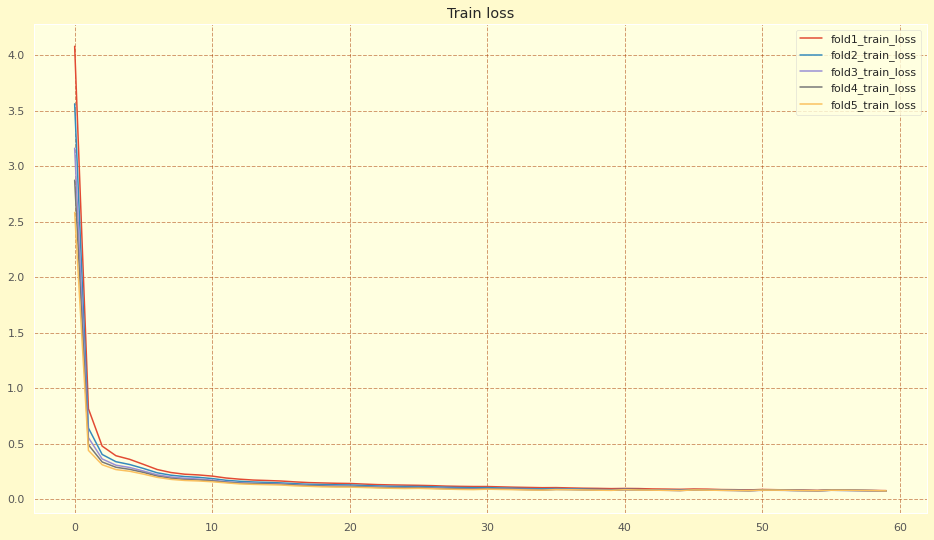

In [17]:
for i in stats.filter(like='train', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train loss')
plt.legend()  

# Valid RMSE

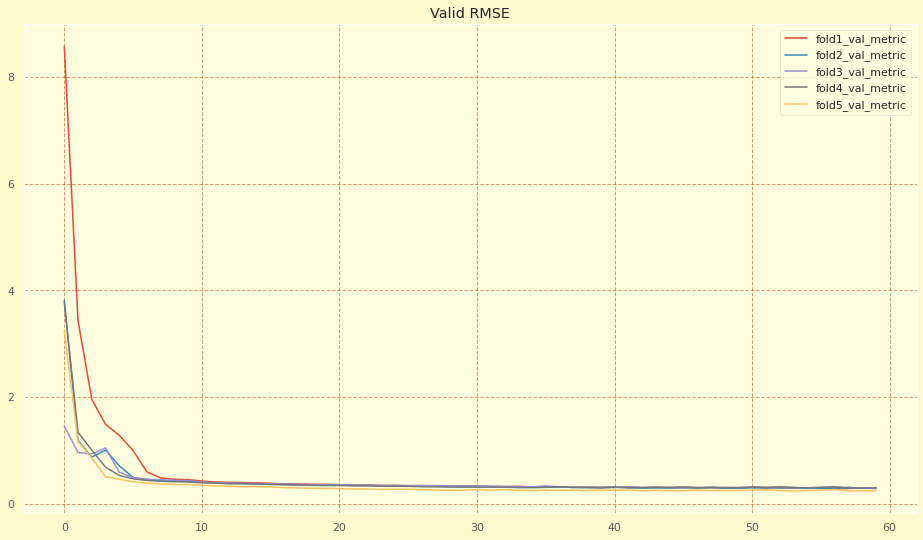

In [18]:
for i in stats.filter(like='val', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Valid RMSE')
plt.legend() 

# Feature Importances

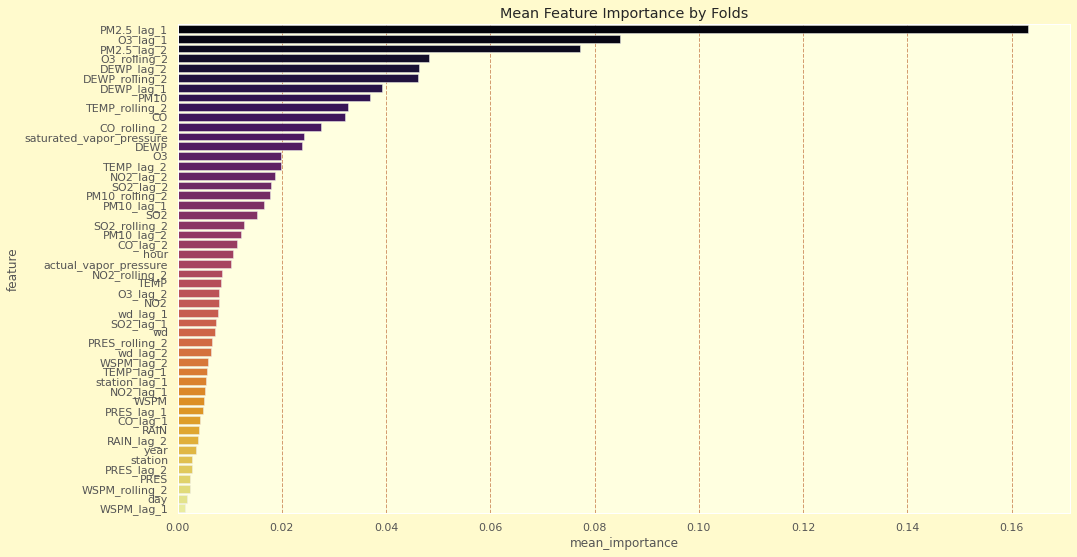

In [19]:
feature_importances['mean_importance']=feature_importances[['importance_fold0+1','importance_fold1+1']].mean(axis=1)
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)
sns.barplot(y=feature_importances['feature'][:50],x=feature_importances['mean_importance'][:50], palette='inferno')
plt.title('Mean Feature Importance by Folds')
plt.show()

# Masks

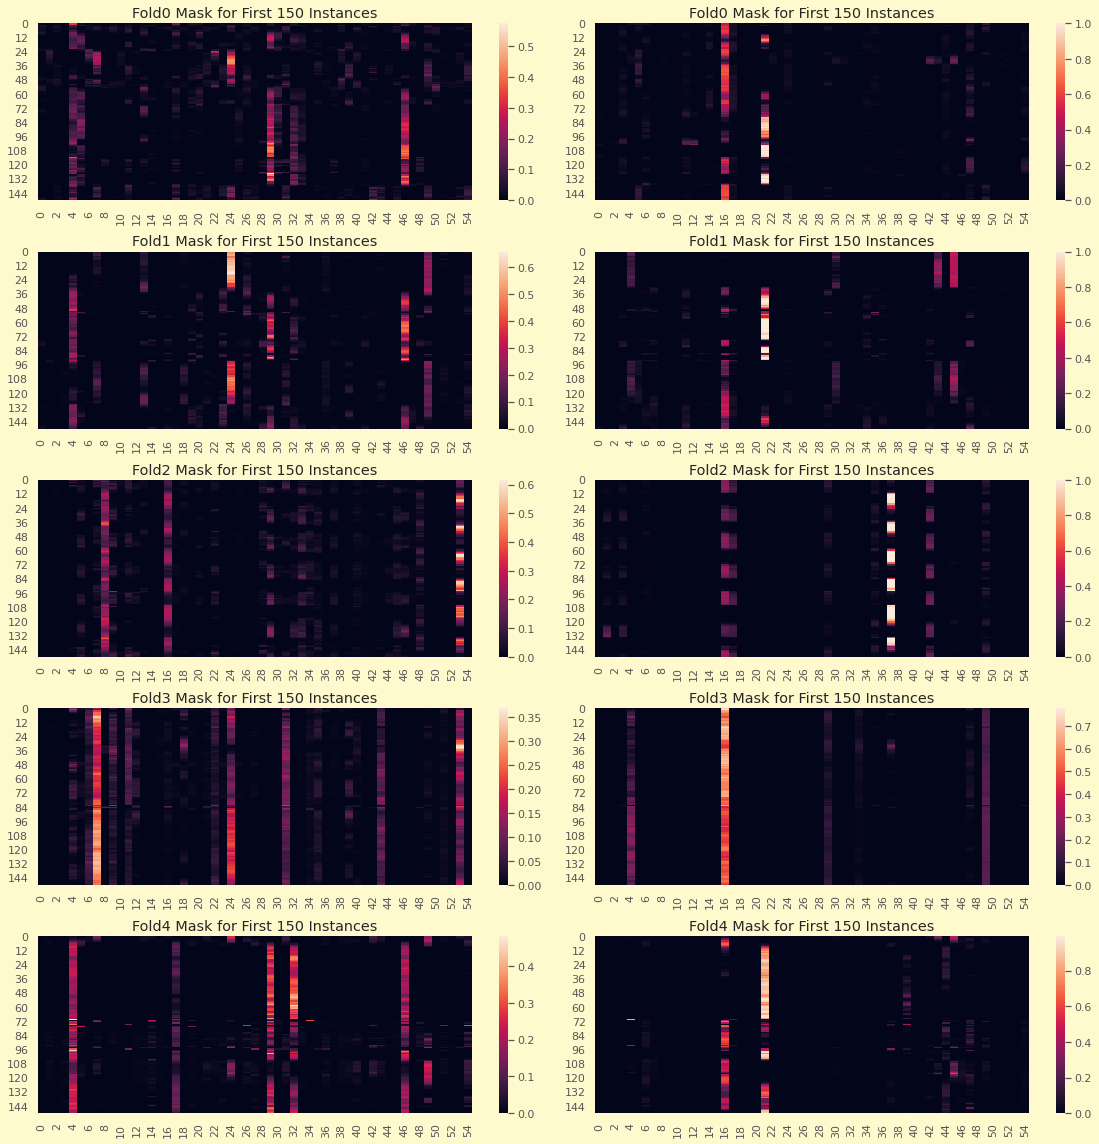

In [20]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))
axs = axs.flatten()

k=-1    
for i, (mask, j) in enumerate(zip(masks_, axs)):
    sns.heatmap(mask[:150], ax=j)
    if i%2 == 0:
        k+=1
    j.set_title((f"Fold{k} Mask for First 150 Instances"))
plt.tight_layout()

# Explain Matrices

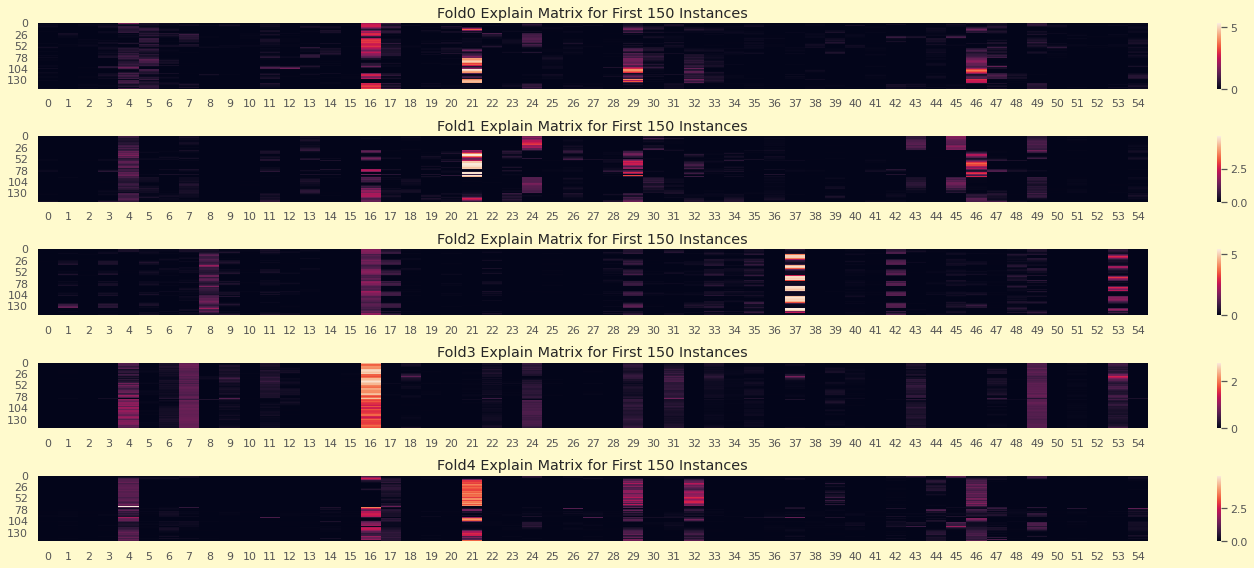

In [21]:
fig, axs = plt.subplots(len(explain_matrices), 1, figsize=(20,8))
for i,matrix in enumerate(explain_matrices):
    axs[i].set_title(f'Fold{i} Explain Matrix for First 150 Instances')
    sns.heatmap(matrix[:150], ax=axs[i])
plt.tight_layout() 

# Plot predictions vs target

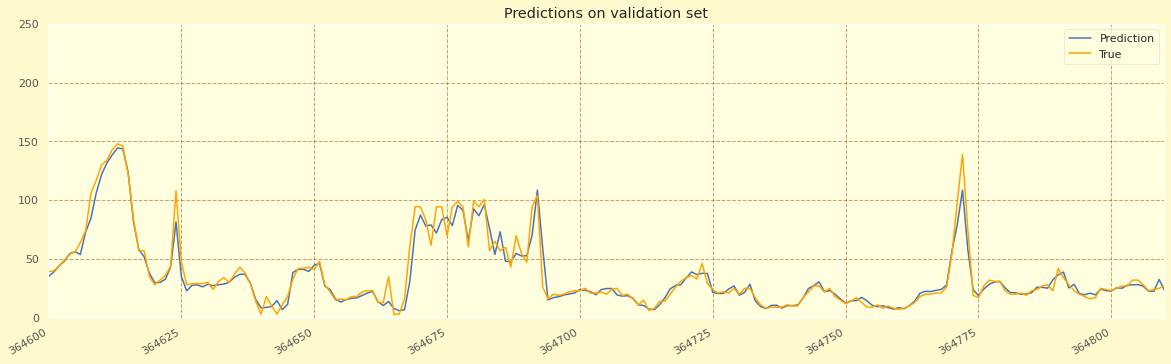

In [22]:
# Create fig size for plotting
fig, ax = plt.subplots(figsize=(20, 6))
# Plot the prediction
ax.plot(test["PM2.5"].index, np.exp(predictions_tabnet), color='b', label='Prediction')
# Plot the true values 
ax.plot(test["PM2.5"].index, test["PM2.5"], color='orange', label='True')

# Set title
ax.set_title("PM2.5", fontweight="bold", size=16)
# Set legend
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([364600, 364810, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()
fig.savefig('test_set_predictions.png')